In [1]:
pip install tensorflow-metal

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.15.0
GPU available: True


In [3]:
import os

In [4]:
# Load embeddings
X_train = np.load('data/embeddings/train_embeddings.npy')
X_val = np.load('data/embeddings/val_embeddings.npy')
X_test = np.load('data/embeddings/test_embeddings.npy')

# Load labels
y_train = np.load('data/processed/y_train.npy')
y_val = np.load('data/processed/y_val.npy')
y_test = np.load('data/processed/y_test.npy')

# Load class weights
with open('data/processed/class_weights.pkl', 'rb') as f:
    class_weight_dict = pickle.load(f)

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}")
print(f"\nClass weights: {class_weight_dict}")

Train: (79998, 384), (79998,)
Val:   (10000, 384), (10000,)
Test:  (10000, 384), (10000,)

Class weights: {0: 2.2781717214865442, 1: 4.0208082026538, 2: 0.4324613613142829}


## MLP Model

- Input: 384-dim embeddings
- Hidden layers: 256 → 128 → 64
- BatchNormalization + Dropout (0.2-0.3)
- Output: 3 classes (softmax)

In [5]:
def build_mlp():
    model = keras.Sequential([
        layers.Input(shape=(384,)),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(3, activation='softmax')
    ], name='MLP_Baseline')
    
    return model

mlp_model = build_mlp()
mlp_model.summary()

2025-12-05 17:36:52.010385: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-05 17:36:52.010481: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-05 17:36:52.010494: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-05 17:36:52.010935: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-05 17:36:52.011481: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "MLP_Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               98560     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)              

## Compile Model 
- Optimizer: Adam 
- Loss: Sparse categorical crossentropy with class weights
- Metrics: Accuracy

In [6]:
mlp_model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Callbacks

In [7]:
# Create models directory
Path('models').mkdir(exist_ok=True)

callback_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'models/mlp_best.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
]


## Train Model

In [8]:
history = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callback_list,
    verbose=1
)

Epoch 1/50


2025-12-05 17:36:53.139652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2500/2500 [==============================] - 46s 18ms/step - loss: 0.8708 - accuracy: 0.6534 - val_loss: 0.7237 - val_accuracy: 0.6878 - lr: 0.0010
Epoch 2/50
2500/2500 [==============================] - 27s 11ms/step - loss: 0.8060 - accuracy: 0.6908 - val_loss: 0.6792 - val_accuracy: 0.7324 - lr: 0.0010
Epoch 3/50
2500/2500 [==============================] - 27s 11ms/step - loss: 0.8059 - accuracy: 0.6938 - val_loss: 0.6988 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 4/50
2500/2500 [==============================] - 27s 11ms/step - loss: 0.8038 - accuracy: 0.6981 - val_loss: 0.7193 - val_accuracy: 0.7043 - lr: 0.0010
Epoch 5/50
2500/2500 [==============================] - 27s 11ms/step - loss: 0.8063 - accuracy: 0.6951 - val_loss: 0.7836 - val_accuracy: 0.6801 - lr: 0.0010
Epoch 6/50
2500/2500 [==============================] - 27s 11ms/step - loss: 0.8048 - accuracy: 0.6966 - val_loss: 0.7029 - val_accuracy: 0.7135 - lr: 0.0010
Epoch 7/50
2499/2500 [============================>.] - E

## Training History Visualization

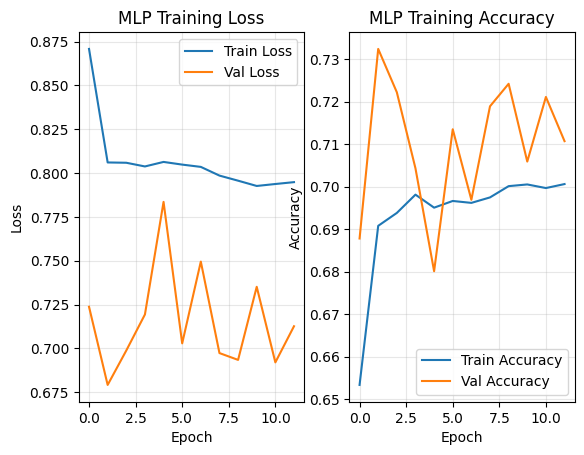

  Train Loss: 0.7948
  Train Acc:  0.7006
  Val Loss:   0.7126
  Val Acc:    0.7107


In [9]:
fig, axes = plt.subplots(1, 2)

# Loss curves
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('MLP Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy curves
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_title('MLP Training Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.savefig('results/figures/mlp_training_curves.png')
plt.show()

print(f"  Train Loss: {history.history['loss'][-1]:.4f}")
print(f"  Train Acc:  {history.history['accuracy'][-1]:.4f}")
print(f"  Val Loss:   {history.history['val_loss'][-1]:.4f}")
print(f"  Val Acc:    {history.history['val_accuracy'][-1]:.4f}")

## Evaluate on Test Set

In [10]:
test_loss, test_acc = mlp_model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Get predictions
y_pred_probs = mlp_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import f1_score
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Macro F1
print(f"Macro F1-Score: {macro_f1:.4f} ({macro_f1*100:.2f}%)")

Test Loss:     0.6808
Test Accuracy: 0.7329 (73.29%)
Macro F1-Score: 0.5725 (57.25%)


## Classification Report

In [11]:
class_names = ['Negative', 'Neutral', 'Positive']

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

Classification Report:
              precision    recall  f1-score   support

    Negative     0.5406    0.6924    0.6071      1463
     Neutral     0.1933    0.4053    0.2618       829
    Positive     0.9361    0.7758    0.8485      7708

    accuracy                         0.7329     10000
   macro avg     0.5567    0.6245    0.5725     10000
weighted avg     0.8167    0.7329    0.7645     10000



## Confusion Matrix

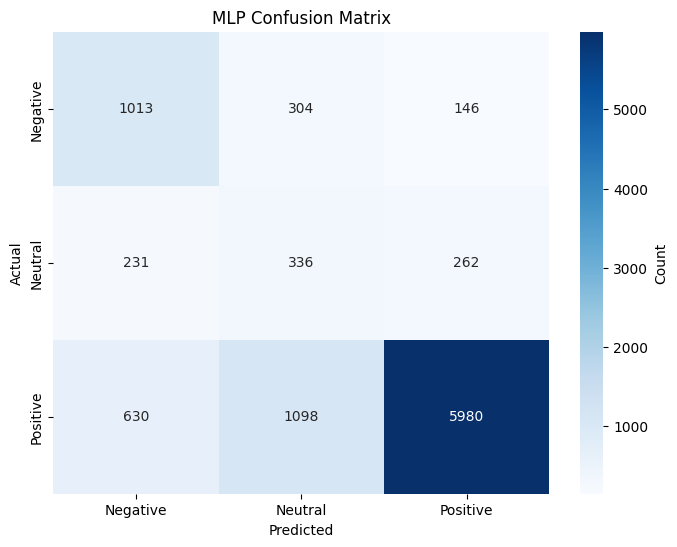

In [12]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
ax.set_title('MLP Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.savefig('results/figures/mlp_confusion_matrix.png')
plt.show()

## Per-Class Performance

   Class  Precision   Recall  F1-Score  Support
Negative   0.540555 0.692413  0.607132     1463
 Neutral   0.193326 0.405308  0.261784      829
Positive   0.936130 0.775817  0.848468     7708


/var/folders/sl/hvvwjftn2r1bjbl01xd6_f040000gn/T/ipykernel_26263/1924098597.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names)


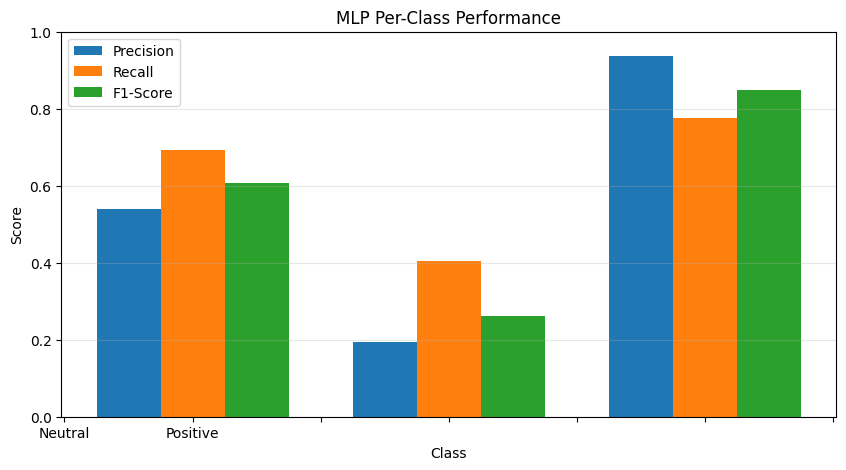

In [13]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

# performance dataframe
perf_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print(perf_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(class_names))
width = 0.25

ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1, width, label='F1-Score')

ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('MLP Per-Class Performance')
ax.set_xticklabels(class_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.savefig('results/figures/mlp_per_class_performance.png')
plt.show()

## Error Analysis

In [14]:
# Find misclassified examples
errors = y_test != y_pred
error_indices = np.where(errors)[0]

print(f"Total errors: {len(error_indices)} / {len(y_test)} ({len(error_indices)/len(y_test)*100:.2f}%)")

# Count errors by true class
for i, class_name in enumerate(class_names):
    class_mask = y_test == i
    class_errors = np.sum(errors & class_mask)
    class_total = np.sum(class_mask)
    print(f"  {class_name}: {class_errors}/{class_total} ({class_errors/class_total*100:.1f}%)")

Total errors: 2671 / 10000 (26.71%)
  Negative: 450/1463 (30.8%)
  Neutral: 493/829 (59.5%)
  Positive: 1728/7708 (22.4%)


## Save Results

In [15]:
results = {
    'model': 'MLP',
    'test_accuracy': float(test_acc),
    'test_macro_f1': float(macro_f1),  
    'test_loss': float(test_loss),
    'precision': precision.tolist(),
    'recall': recall.tolist(),
    'f1': f1.tolist(),
    'confusion_matrix': cm.tolist(),
    'epochs_trained': len(history.history['loss']),
    'parameters': mlp_model.count_params()
}

import json
with open('results/metrics/mlp_results.json', 'w') as f:
    json.dump(results, f, indent=2)

# Save predictions
np.save('results/metrics/mlp_predictions.npy', y_pred)
np.save('results/metrics/mlp_probabilities.npy', y_pred_probs)